In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

master_df_encoded = pd.read_csv('/app/src/services/tables/master_df_encoded.csv')


# --- 1. 한글 폰트 설정 ---
def set_korean_font():
    font_names = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in font_names:
        plt.rcParams['font.family'] = 'NanumGothic'
    elif 'Malgun Gothic' in font_names:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif 'AppleGothic' in font_names:
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        plt.rcParams['font.family'] = 'DejaVu Sans'

set_korean_font()
plt.rcParams['axes.unicode_minus'] = False

# --- 2. 데이터 준비 & 전처리 (이전과 동일) ---

# 데이터 타입 정리
for col in master_df_encoded.columns:
    if master_df_encoded[col].dtype == 'object' and col not in ['사번', '재직여부', '퇴사자여부']:
        master_df_encoded[col] = pd.to_numeric(master_df_encoded[col], errors='coerce')
master_df_encoded.fillna(master_df_encoded.median(numeric_only=True), inplace=True)

# --- 3. 데이터 비율 9:1 조정 ---
df_leavers = master_df_encoded[master_df_encoded['퇴사자여부'] == 1]
df_active = (master_df_encoded[(master_df_encoded['퇴사자여부'] == 0) & (master_df_encoded["재직일수"] >= 182)]
)

n_leavers = len(df_leavers)
n_required_active = n_leavers * 6

# 재직자 뻥튀기 (Oversampling)
df_active_oversampled = df_active.sample(n=n_required_active, replace=True, random_state=42)
balanced_df = pd.concat([df_leavers, df_active_oversampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

drop_cols = ['사번', '재직여부', '퇴사자여부']
feature_cols = [col for col in balanced_df.columns if col not in drop_cols]

X_train = balanced_df[feature_cols].astype(float)
y_train = balanced_df['퇴사자여부'].astype(float)

# --- 4. 모델 학습 (가중치 10만 적용) ---
weight_ratio = 70  # (6:1 불균형을 상쇄할 만큼의 힘)

model = xgb.XGBClassifier(
    n_estimators=weight_ratio, 
    max_depth=2,             
    learning_rate=0.1, 
    scale_pos_weight=weight_ratio,  # <--- [핵심] 이 값이 높을수록 퇴사 확률이 높게 나옴
    random_state=42, 
    min_child_weight=10, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
model.fit(X_train, y_train)
print("모델 학습 완료!")

# --- 5. Global SHAP 분석 ---
X_sample = X_train.sample(n=min(2000, len(X_train)), random_state=42)
background_data = shap.sample(X_train, 100)

explainer = shap.TreeExplainer(
    model, 
    data=background_data, 
    feature_perturbation="interventional",
    model_output="probability"
)

print("Global SHAP 값 계산 중... (잠시만 기다려주세요)")
shap_values_global = explainer(X_sample)

# --- 6. 단위 변환 (확률 -> 퍼센트) ---
shap_values_global.values = shap_values_global.values * 100
shap_values_global.base_values = shap_values_global.base_values * 100

/usr/local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [07:47:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


모델 학습 완료!
Global SHAP 값 계산 중... (잠시만 기다려주세요)


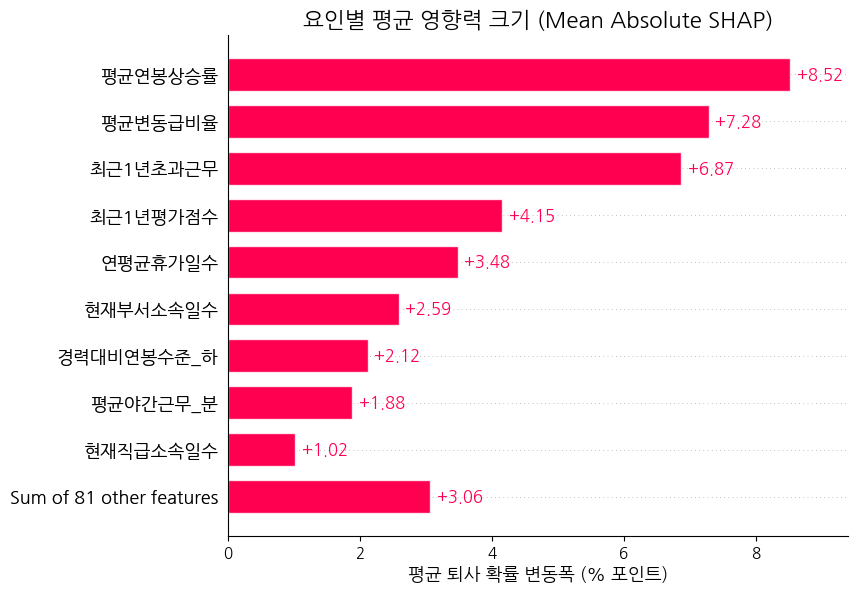

In [3]:
# --- 7. (옵션) 단순 중요도 Bar Plot ---
plt.figure(figsize=(10, 6))
shap.plots.bar(
    shap_values_global, 
    max_display=10, 
    show=False
)
plt.title("요인별 평균 영향력 크기 (Mean Absolute SHAP)", fontsize=16)
plt.xlabel("평균 퇴사 확률 변동폭 (% 포인트)")
plt.show()


[전사 퇴사 위험 핵심 요인 (Global View)]


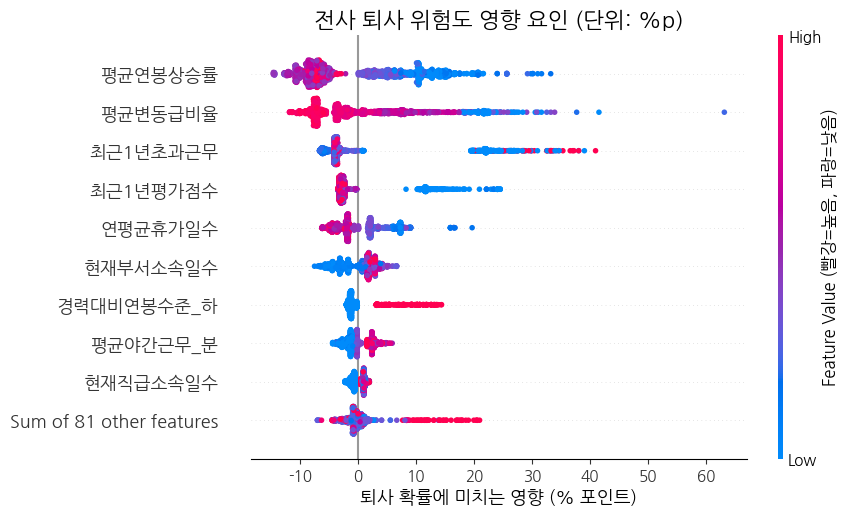

In [4]:
# --- 8. 시각화 (Beeswarm Plot) ---
print("\n[전사 퇴사 위험 핵심 요인 (Global View)]")
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(
    shap_values_global, 
    max_display=10,    
    show=False,
    color_bar_label="Feature Value (빨강=높음, 파랑=낮음)"
)
plt.title("전사 퇴사 위험도 영향 요인 (단위: %p)", fontsize=16)
plt.xlabel("퇴사 확률에 미치는 영향 (% 포인트)")
plt.show()


[심층 분석] 퇴사 위험도에 가장 큰 영향을 미치는 Top 10개 요인에 대한 의존성 분석


<Figure size 1000x600 with 0 Axes>

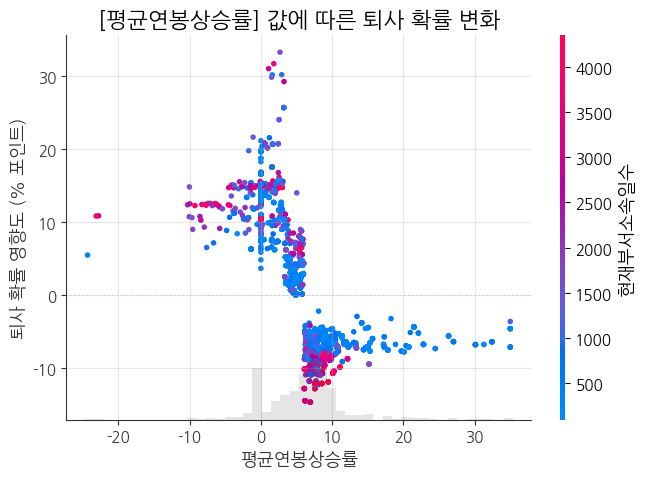

<Figure size 1000x600 with 0 Axes>

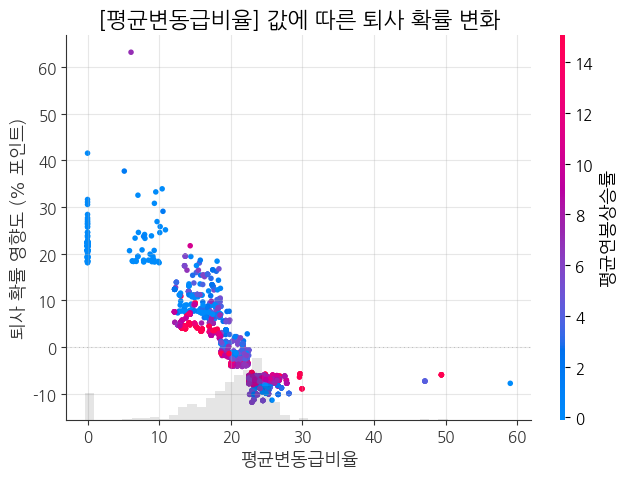

<Figure size 1000x600 with 0 Axes>

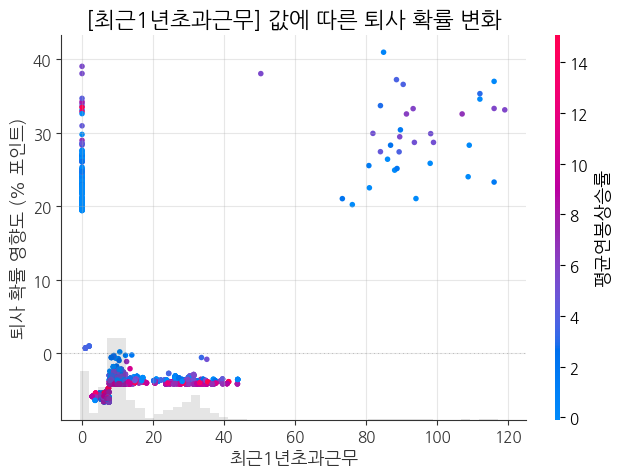

<Figure size 1000x600 with 0 Axes>

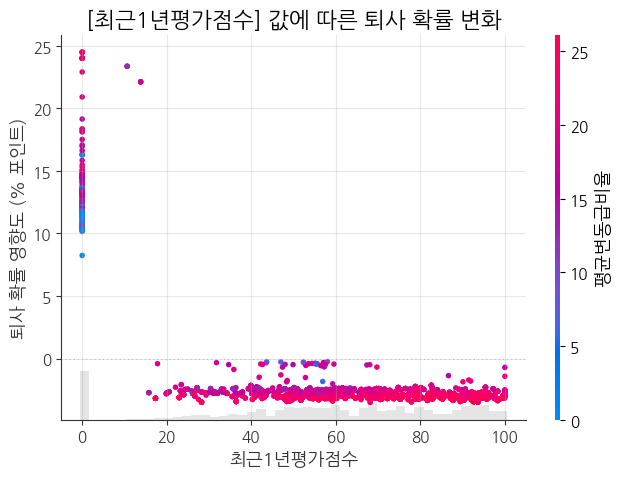

<Figure size 1000x600 with 0 Axes>

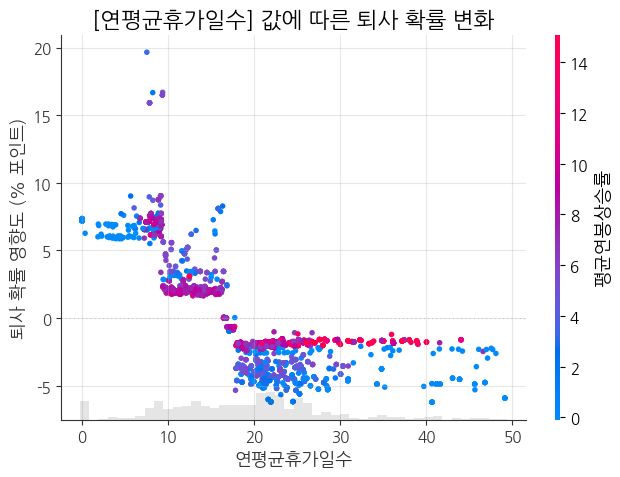

<Figure size 1000x600 with 0 Axes>

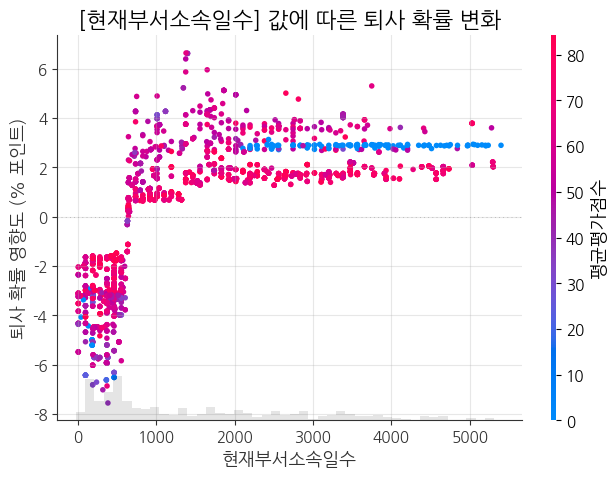

<Figure size 1000x600 with 0 Axes>

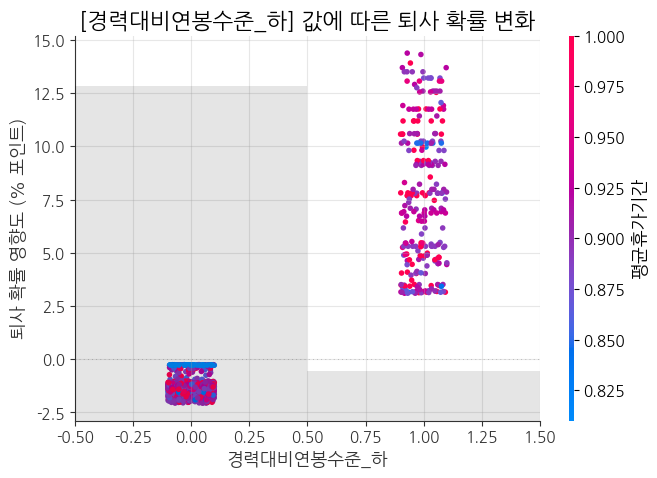

<Figure size 1000x600 with 0 Axes>

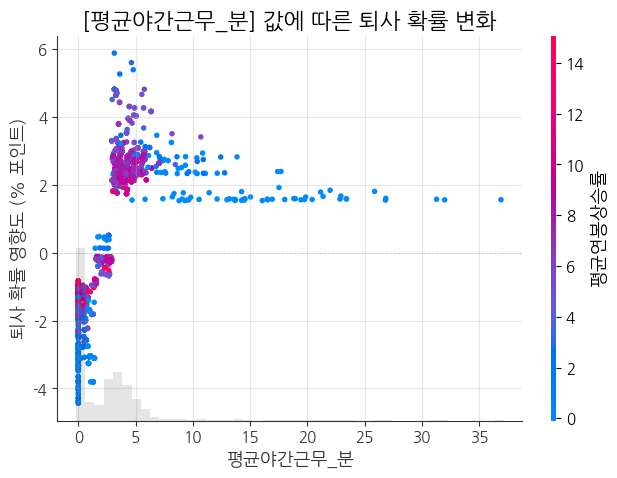

<Figure size 1000x600 with 0 Axes>

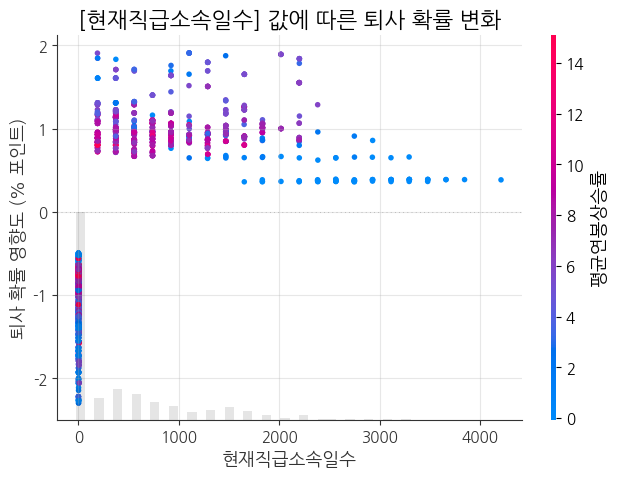

<Figure size 1000x600 with 0 Axes>

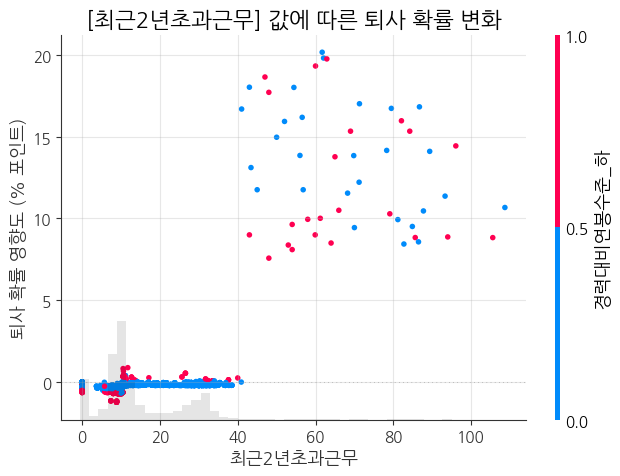


--- 분석 완료 ---
총 10개의 Dependence Plot 객체가 생성되었습니다.
저장된 변수명: ['평균연봉상승률', '평균변동급비율', '최근1년초과근무', '최근1년평가점수', '연평균휴가일수', '현재부서소속일수', '경력대비연봉수준_하', '평균야간근무_분', '현재직급소속일수', '최근2년초과근무']


In [5]:
# =============================================================================
# 🎨 [추가] SHAP Dependence Plot (Top 10)
# =============================================================================
# 가장 중요한 변수 Top 10을 자동으로 찾아 상세 분석 그래프를 그리고, 각 그래프 객체를 저장합니다.

# 1. 가장 중요한 변수 Top 10의 인덱스와 이름 찾기
top_n = 10
mean_abs_shap = np.abs(shap_values_global.values).mean(0)
top_feature_indices = np.argsort(mean_abs_shap)[-top_n:][::-1] # 내림차순 정렬
top_feature_names = [shap_values_global.feature_names[i] for i in top_feature_indices]

print(f"\n[심층 분석] 퇴사 위험도에 가장 큰 영향을 미치는 Top {top_n}개 요인에 대한 의존성 분석")

# 2. 각 변수에 대한 Dependence Plot을 그리고 객체로 저장
dependence_plots = {}

for feature_name in top_feature_names:
    # 새 Figure 객체를 생성하여 각 그래프가 독립적으로 그려지도록 함
    fig = plt.figure(figsize=(10, 6))

    # SHAP 의존성 플롯 생성
    shap.plots.scatter(
        shap_values_global[:, feature_name],
        color=shap_values_global,
        show=False
    )

    plt.title(f"[{feature_name}] 값에 따른 퇴사 확률 변화", fontsize=16)
    plt.ylabel("퇴사 확률 영향도 (% 포인트)")
    plt.grid(True, alpha=0.3)
    plt.show() # 노트북에 그래프 표시

    # 생성된 그래프 객체를 딕셔너리에 저장 (Streamlit 등에서 활용 가능)
    dependence_plots[feature_name] = fig
    # plt.close(fig) # 바로 닫아서 메모리 관리 (노트북에 표시하지 않을 경우 사용)

print("\n--- 분석 완료 ---")
print(f"총 {len(dependence_plots)}개의 Dependence Plot 객체가 생성되었습니다.")
print("저장된 변수명:", list(dependence_plots.keys()))

In [6]:
master_df_encoded['평균연봉상승률'].describe()

count    1000.000000
mean        3.334363
std         5.900700
min       -24.330000
25%         0.000000
50%         2.205000
75%         6.924167
max        35.000000
Name: 평균연봉상승률, dtype: float64

In [7]:
master_df_encoded['평균연봉상승률'].value_counts()

평균연봉상승률
 0.000000     296
 35.000000      3
-4.153333       2
 4.510000       2
 6.780000       2
             ... 
 9.073333       1
 2.205000       1
 5.028000       1
 5.111667       1
-5.785000       1
Name: count, Length: 689, dtype: int64